In [37]:
import cv2
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import os

In [38]:
import cv2
import numpy as np

def lucas_kanade_registration(img1_path, img2_path):
    """
    Registers img1 to img2 using Lucas-Kanade Optical Flow.
    
    Parameters:
        img1_path (str): Path to the first image (moving image).
        img2_path (str): Path to the second image (fixed image).
    
    Returns:
        numpy.ndarray: The warped image (registered img1).
    """
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    if img1 is None or img2 is None:
        raise ValueError("Error loading images. Check the file paths.")

    # Detect Shi-Tomasi corners in img1
    feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
    p0 = cv2.goodFeaturesToTrack(img1, mask=None, **feature_params)

    if p0 is None or len(p0) == 0:
        raise ValueError("No feature points found in img1. Try adjusting parameters.")

    # Define Lucas-Kanade optical flow parameters
    lk_params = dict(winSize=(15, 15), maxLevel=3,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    # Compute Optical Flow
    p1, st, _ = cv2.calcOpticalFlowPyrLK(img1, img2, p0, None, **lk_params)

    if p1 is None or len(p1) == 0:
        raise ValueError("Optical flow computation failed. Check input images.")

    # Keep only the points where flow was found
    p0 = p0[st == 1]
    p1 = p1[st == 1]

    # Compute transformation matrix (Affine)
    transform_matrix, _ = cv2.estimateAffinePartial2D(p0, p1)

    if transform_matrix is None:
        raise ValueError("Transformation matrix could not be computed.")

    # Apply the transformation to img1 (warp img1 to align with img2)
    height, width = img2.shape  # Output image size matches img2
    registered_img = cv2.warpAffine(img1, transform_matrix, (width, height))

    return registered_img  # Return the warped image


In [39]:
def farneback_registration(img1_path, img2_path):
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    if img1 is None or img2 is None:
        raise ValueError("Error loading images. Check file paths.")

    # Compute optical flow
    flow = cv2.calcOpticalFlowFarneback(img1, img2, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    # Image dimensions
    h, w = img1.shape

    # Generate coordinate grid
    coords_x, coords_y = np.meshgrid(np.arange(w), np.arange(h))
    
    # Apply flow displacements
    flow_map = np.stack((coords_x + flow[..., 0], coords_y + flow[..., 1]), axis=2)

    # Clip values to ensure they remain within valid image bounds
    flow_map[..., 0] = np.clip(flow_map[..., 0], 0, w - 1)
    flow_map[..., 1] = np.clip(flow_map[..., 1], 0, h - 1)

    # Ensure correct data type
    flow_map = flow_map.astype(np.float32)

    # Apply remapping
    remapped_img = cv2.remap(img1, flow_map, None, cv2.INTER_LINEAR)

    return remapped_img

In [40]:
def sift_registration(img1_path, img2_path):
    """
    Registers img1 with respect to img2 using SIFT keypoints and Homography.
    Returns the registered image.
    """
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    # SIFT detector
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # Match features
    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
    matches = flann.knnMatch(des1, des2, k=2)

    # Apply Lowe's ratio test
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

    # Compute transformation
    if len(good_matches) < 4:  # Not enough points for transformation
        return None
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    homography_matrix, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Warp image
    registered_img = cv2.warpPerspective(img1, homography_matrix, (img2.shape[1], img2.shape[0]))

    return registered_img

In [41]:
def demons_registration(img1_path, img2_path):
    """
    Registers img1 with respect to img2 using Demons Registration.
    Returns the registered image.
    """
    img1 = sitk.ReadImage(img1_path, sitk.sitkFloat32)
    img2 = sitk.ReadImage(img2_path, sitk.sitkFloat32)

    # Apply Demons Registration
    demons = sitk.DemonsRegistrationFilter()
    demons.SetNumberOfIterations(100)
    displacement_field = demons.Execute(img1, img2)

    # Warp image using displacement field
    registered_img = sitk.Warp(img1, displacement_field)

    # Normalize to 8-bit and convert back to SimpleITK Image
    registered_img_array = sitk.GetArrayFromImage(registered_img)
    registered_img_array = (255 * (registered_img_array - registered_img_array.min()) /
                            (registered_img_array.max() - registered_img_array.min())).astype(np.uint8)
    registered_img = sitk.GetImageFromArray(registered_img_array)

    return registered_img

Lucas-Kanade -> SSIM: 0.2743, MSE: 97.87
Farneback -> SSIM: 0.0771, MSE: 100.77
SIFT -> SSIM: 0.2371, MSE: 98.65
Demons -> SSIM: 0.0094, MSE: 103.18


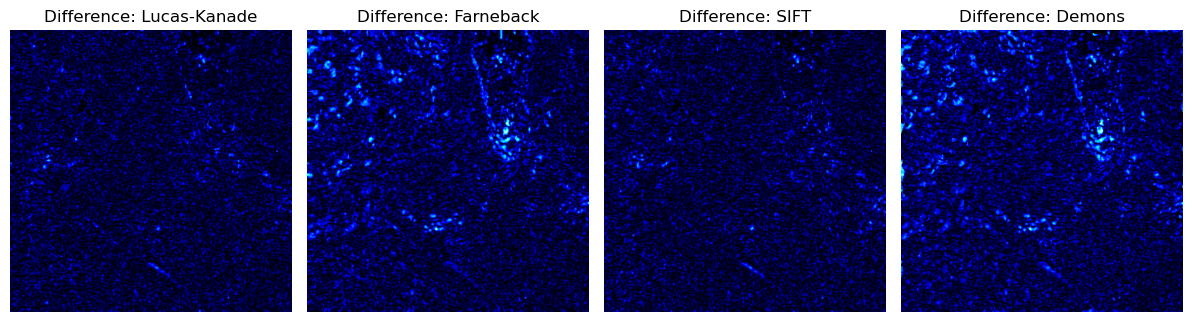

In [42]:


# Create output directory if it doesn't exist
output_folder = "output"
os.makedirs(output_folder, exist_ok=True)

def measure_similarity(moving_img, registered_img):
    """
    Measures similarity between two images using SSIM and MSE.

    Parameters:
        moving_img (numpy.ndarray): The target image (img1).
        registered_img (numpy.ndarray or sitk.Image): The warped img0 after registration.

    Returns:
        dict: Dictionary containing SSIM and MSE values.
    """
    if moving_img is None or registered_img is None:
        return {"Error": "One or both images are missing."}

    # Convert SimpleITK Image to NumPy array if necessary
    if isinstance(registered_img, sitk.Image):
        registered_img = sitk.GetArrayFromImage(registered_img)

    # Ensure images are grayscale
    if len(moving_img.shape) > 2:
        moving_img = cv2.cvtColor(moving_img, cv2.COLOR_BGR2GRAY)
    if len(registered_img.shape) > 2:
        registered_img = cv2.cvtColor(registered_img, cv2.COLOR_BGR2GRAY)

    # Resize registered image if dimensions don't match
    if moving_img.shape != registered_img.shape:
        registered_img = cv2.resize(registered_img, (moving_img.shape[1], moving_img.shape[0]))

    # Compute SSIM (higher is better, max = 1.0)
    similarity_ssim = ssim(moving_img, registered_img, data_range=registered_img.max() - registered_img.min())

    # Compute Mean Squared Error (MSE, lower is better, min = 0)
    mse = np.mean((moving_img - registered_img) ** 2)

    return {"SSIM": similarity_ssim, "MSE": mse}

def compute_difference(moving_img, registered_img):
    """
    Computes the absolute difference between the registered image and the moving image.

    Parameters:
        moving_img (numpy.ndarray): The target image (img1).
        registered_img (numpy.ndarray): The registered (warped) img0.

    Returns:
        numpy.ndarray: The absolute difference image.
    """
    if registered_img is None:
        return None

    # Ensure both images have the same size
    if moving_img.shape != registered_img.shape:
        registered_img = cv2.resize(registered_img, (moving_img.shape[1], moving_img.shape[0]))

    # Compute absolute difference
    diff_img = cv2.absdiff(moving_img, registered_img)

    # Apply the difference map using hot colormap
    diff_colormap = cv2.applyColorMap(diff_img, cv2.COLORMAP_HOT)

    return diff_colormap  # Return the difference image in color

def visualize_difference_comparison(moving_img, registered_images):
    """
    Creates a single figure displaying all difference images side by side.
    Saves the figure for comparison.
    """
    methods = list(registered_images.keys())
    num_methods = len(methods)

    plt.figure(figsize=(15, 5))

    for i, method in enumerate(methods):
        diff_img = compute_difference(moving_img, registered_images[method])
        if diff_img is not None:
            plt.subplot(1, num_methods + 1, i + 1)
            plt.imshow(diff_img)
            plt.title(f"Difference: {method}")
            plt.axis("off")

    # Save the difference comparison plot
    diff_plot_path = os.path.join(output_folder, "difference_comparison.png")
    plt.savefig(diff_plot_path)

    plt.tight_layout()
    plt.show()

# Load target image (moving image, img1)
img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)

# Generate registered images by warping img0
lk_reg = lucas_kanade_registration(img0_path, img1_path)  # img0 -> img1
fb_reg = farneback_registration(img0_path, img1_path)
sift_reg = sift_registration(img0_path, img1_path)
demons_reg = demons_registration(img0_path, img1_path)

# Convert SimpleITK image to NumPy array if necessary
if isinstance(demons_reg, sitk.Image):
    demons_reg = sitk.GetArrayFromImage(demons_reg)

# Store registered images
registered_images = {
    "Lucas-Kanade": lk_reg,
    "Farneback": fb_reg,
    "SIFT": sift_reg,
    "Demons": demons_reg
}

# Compute similarity: Compare warped img0 (registered images) with img1
similarity_results = {
    method: measure_similarity(img1, img) if img is not None else None
    for method, img in registered_images.items()
}

# Print and save similarity scores
similarity_file = os.path.join(output_folder, "similarity_scores.txt")
with open(similarity_file, "w") as f:
    for method, scores in similarity_results.items():
        if scores and "Error" not in scores:
            score_str = f"{method} -> SSIM: {scores['SSIM']:.4f}, MSE: {scores['MSE']:.2f}"
            print(score_str)
            f.write(score_str + "\n")
        else:
            print(f"{method} -> Registration failed.")
            f.write(f"{method} -> Registration failed.\n")

# Save registered images
for method, img in registered_images.items():
    if img is not None:
        img_path = os.path.join(output_folder, f"{method}_registered.png")
        cv2.imwrite(img_path, img)

# Display and save difference comparison plot
visualize_difference_comparison(img1, registered_images)


In [6]:
import os
import fitz  # PyMuPDF
from PIL import Image, ImageFilter
import io

def apply_median_filter(image, size=3):
    """
    Apply a median filter to the given image.
    :param image: PIL Image object
    :param size: Filter size (default is 3)
    :return: Filtered PIL Image object
    """
    return image.filter(ImageFilter.MedianFilter(size))

def extract_images_from_pdf(pdf_folder):
    output_folder = os.path.join(pdf_folder, "extracted_images")
    filtered_folder = os.path.join(pdf_folder, "filtered_images")
    os.makedirs(output_folder, exist_ok=True)
    os.makedirs(filtered_folder, exist_ok=True)

    # Process each PDF in the folder
    for pdf_file in os.listdir(pdf_folder):
        if pdf_file.lower().endswith(".pdf"):
            pdf_path = os.path.join(pdf_folder, pdf_file)
            doc = fitz.open(pdf_path)

            for page_num, page in enumerate(doc):
                for img_index, img in enumerate(page.get_images(full=True)):
                    xref = img[0]  # Extract image reference
                    image = doc.extract_image(xref)
                    img_bytes = image["image"]

                    # Convert to PIL image
                    img_pil = Image.open(io.BytesIO(img_bytes))

                    # Save unfiltered image
                    unfiltered_filename = os.path.join(output_folder, f"{os.path.splitext(pdf_file)[0]}_page{page_num+1}.png")
                    img_pil.save(unfiltered_filename, "PNG")

                    # Apply median filter and save filtered image
                    img_filtered = apply_median_filter(img_pil)
                    filtered_filename = os.path.join(filtered_folder, f"{os.path.splitext(pdf_file)[0]}_page{page_num+1}_filtered.png")
                    img_filtered.save(filtered_filename, "PNG")

                    print(img_pil.shape())
                    print(f"Unfiltered image saved: {unfiltered_filename}")
                    print(f"Filtered image saved: {filtered_filename}")

    print("✅ Image extraction and filtering complete!")

# Set the folder containing PDFs
pdf_folder = "test_images_1"

extract_images_from_pdf(pdf_folder)


RuntimeError: Directory 'static/' does not exist